In [1]:
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A

import ssl
import os
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from utils import *
from data_loader import *
from train import * 
from segmentation import *
from obstacle_detection_utils import *

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Instantiate the model
object_model = ObjectDetectionModel().to(device)
object_model.eval()

ObjectDetectionModel(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [5]:
save_path = "DeepLabV3_ResNet50.pt"
model = SegmentationModel(23)

load_path = f"DeepLabV3_ResNet50.pt"
if os.path.exists(load_path):
    model = torch.load(load_path)
    print(f"Loaded {save_path}")

Loaded DeepLabV3_ResNet50.pt


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
use_patch = False
save_path = "DeepLabV3_ResNet50.pt"
batch_size = 3
model_num = 2
num_classes = 23
max_lr = 1e-3
epochs = 25
weight_decay = 1e-4

In [7]:
img_path = (
    "archive/dataset/semantic_drone_dataset/original_images/"
)
mask_path = "archive/dataset/semantic_drone_dataset/label_images_semantic/"

In [8]:
df = create_image_id_dataframe(img_path)

X_train_and_val, X_test = train_test_split(
    df["id"].values, test_size=0.1, random_state=19
)
X_train, X_val = train_test_split(X_train_and_val, test_size=0.15, random_state=19)

print("Train Size ", len(X_train))
print("Test Size ", len(X_test))
print("Val Size ", len(X_val))

t_train = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_val = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

train_dataset = DataGenerator(
    img_path,
    mask_path,
    X_train,
    mean,
    std,
    transform=t_train,
    normalize=True,
    patch=use_patch,
)
val_dataset = DataGenerator(
    img_path, mask_path, X_val, transform=t_val, normalize=True, patch=use_patch
)
test_dataset = DataGenerator(img_path, mask_path, X_test, transform=t_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Size  107
Test Size  15
Val Size  20


In [9]:
image, mask = test_dataset[3]

In [10]:
torch.cuda.empty_cache()


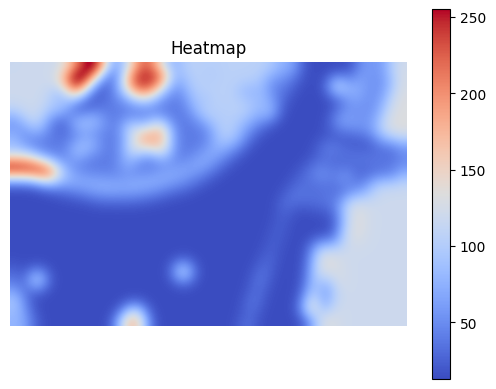

In [11]:
# Get segmentation output
pred_mask, score, _ = predict_image_mask_miou_pixel_accuracy(model, image, mask, device)
seg_img = pred_mask.cpu().numpy()

# Get segmentation heatmap
risk_array = get_risk_map(seg_img, labels, risk_table, gaussian_sigma=25)
visualize_heatmap(risk_array)